<font color='blue'>**SHORTEST ROUTE ALGORITHM BETWEEN CITIES**</font> 

1. Import all the libraries required for this program

In [1]:
import pandas as pd
import random
import numpy as np
import os
import warnings
import folium
import time
import geopy.distance
import matplotlib.pyplot as plt
from multiprocessing import Pool
warnings.filterwarnings('ignore')

2. Import data into python and explore the dataset

In [2]:
######################################## Reading Data ###########################################
df=pd.read_csv("uscities.csv")
df=df.drop(["SNo"],axis=1)
df_original = df
df_len = len(df)
print("Number of observations in dataset is {}".format(df_len))
df.head()

Number of observations in dataset is 28889


,Cities,Lat,Long
0,South Creek,46.9994,-122.3921
1,Roslyn,47.2507,-121.0989
2,Sprague,47.3048,-117.9713
3,Gig Harbor,47.3352,-122.5968
4,Lake Cassidy,48.0639,-122.0920


We initialize 3 lists to store the time taken by each section of the code

In [3]:
##################################### To track time of each section #############################
process=[]
optimization =[]
visual = []

<font color='blue'>**DATA PROCESSING**</font>

3. We randomly sample the data to pick observations for further analysis.
We also keep track of time taken by each block for execution.

In [4]:
####################################### Data Processing ##########################################
df = df_original
t1 = time.time()
df = df.sample(n=1600)
nrows=len(df) #Total no. of cities

4. We assign the maximum and minimum number of ones in the sparse matrix rows

In [5]:
maxdeg=5 #Max. number of ones
mindeg=2 #Min. numbver of ones

5. To reduce time complexity and ease of processing, we convert the input data into a dictionary.

In [6]:
list=[]
df = df.reset_index()
df=df.drop(["index"],axis=1)
dict=df.to_dict('index')

6. We generate random edges for the cities which act as connections/routes between two cities and build a sparse matrix to increase efficiency of the code and ease of retrieval. 
The values dmax and dmin are the actual maximum and mininum number of degrees the graph is constrained to.

In [7]:
# Generate random edges of degree n
edgearr_sparse = np.zeros((nrows,nrows))
# making first n columns as 1
for i in range(0,maxdeg):
    edgearr_sparse[:,i]=1
#  Shuffling the data
for i in range(0,nrows):
    random.shuffle(edgearr_sparse[i])
edgearr_sparse = np.asmatrix(edgearr_sparse)
edgearr_sparse = edgearr_sparse + edgearr_sparse.T
np.fill_diagonal(edgearr_sparse,0)
edgearr_sparse=edgearr_sparse%2
#edgearr_sparse

sumedge = edgearr_sparse.sum(axis=0)
d = []
for i in range(sumedge.shape[1]):
    d.append(sumedge.item(0,i))

#maximum and mininum number of degrees
dmax = max(d)
dmin = min(d)

7. Calculate the air distance between two cities based on the latitude and longitude

In [8]:
#calculate air distance between two points
dict_edges={}
dict_inner={}
for i in range(0,nrows):
    dict_inner={}
#     loop through each column and find distance for each edge
    for j in range(0,nrows):
        if(edgearr_sparse[i,j]==1):
            coord1=(dict[i]["Lat"],dict[i]["Long"])
            coord2=(dict[j]["Lat"],dict[j]["Long"])
            dict_inner[j]=round(geopy.distance.geodesic(coord1, coord2).km,2)            

    dict_edges[i]=dict_inner


8. Store the entire time taken by the data processing block to generate routes and calculate distance between two connected cities

In [9]:
t2= time.time()
process.append(t2-t1)

<font color='blue'>**DIJSKTRA'S ALGORITHM**</font>

Dijkstra’s algorithm is a greedy algorithm to find the shortest path between two nodes in a graph.

Following are the steps of the algorithm:

Let distance of start node from start vertex be 0. Call the starting node as the current node.
Consider all nodes to be in an unvisited list.

Repeat the following steps (until no unvisited node left in the neighbor of the current node or we have reached the end node)

•	Visit the unvisited node with the smallest known distance from the start node. Call that current node. Put starting node in a visited list.

•	For the current node examine the unvisited neighbors (i.e. the nodes connected to the start node).

•	For current node, calculate the distance of each neighbor from the start node. Using the distance of its connecting current node (from the start node) in addition to the distance between current node to the neighbor.

•	If the calculated distance of a node is lesser than its current stored distance from the start node, update the distance.

•	Put the current node in the visited list and then make the neighbor with the smallest distance as the current node. 

Once the above condition is met. If the loop ends due to no unvisited neighboring nodes, the function will return 'No Route Possible'. If the end node is met, we will start with the end node, go to its previous node (which gave the shortest distance) and so on until we reach the start node. The inverse of this list will give the actual path. Moreover, the sum of weights in this graph will give the total distance from the start to end node.


In [10]:
################### Defining algorithm for optimization ###########################
def dijsktra(data, initial, end):
    # shortest paths is a dict of nodes
    # whose value is a tuple of (previous node, weight)
    shortest_paths = {initial: (None, 0)}
    current_node = initial
    visited = []
    
    while current_node != end:
        visited.append(current_node)
        #getting neighbors of the current node
        destinations = data[current_node].keys()
        weight_to_current_node = shortest_paths[current_node][1]

        for next_node in destinations:
            #getting weight of each neighboring node of the current node
            weight = data[current_node][next_node] + weight_to_current_node
            if next_node not in shortest_paths:
                shortest_paths[next_node] = (current_node, weight)
            else:
                current_shortest_weight = shortest_paths[next_node][1]
                #if the calculated weight is lesser, update weight on that node
                if current_shortest_weight > weight:
                    shortest_paths[next_node] = (current_node, weight)
        
        #getting new neighbors 
        next_destinations = {node: shortest_paths[node] for node in shortest_paths if node not in visited}
        
        if not next_destinations:
            return "Route Not Possible"
        # next node is the destination with the lowest weight
        current_node = min(next_destinations, key=lambda k: next_destinations[k][1])
    
    # Work back through destinations in shortest path
    path = []
    weight = 0
    while current_node is not None:
        path.append(current_node)
        next_node = shortest_paths[current_node][0]
        #finding weights of each edge in the shortest path
        if next_node is not None:
            weight += data[next_node][current_node]
        current_node = next_node
    # Reverse path
    path = path[::-1]
    return [path,weight]

9. In Route optimization block, we generate a random origin and destination from the list of cities and use Dijsktra's algorithm to compute the shortest path available, based on the routes generated in the data processing block.
We also compute the time taken by the route optimization block i.e. Dijkstra's algorithm to return the shortest path. 

In [11]:
 ################################### Route Optimization ########################################
    
df_len = len(df)
random.seed(0)
origin = random.randint(1,df_len)
random.seed(1)
destination = random.randint(1,df_len)

t1= time.time()
  
x = dijsktra(dict_edges, origin,destination)

t2= time.time()
a = len(x[0])
numbers = np.arange(1,a+1).tolist()
optimization.append(t2-t1)

In [12]:
print("The path to be followed to reach from origin to destination is {} and the total distance between them is {} kms".format(x[0],x[1]))

The path to be followed to reach from origin to destination is [789, 244, 604, 1372, 1004, 276] and the total distance between them is 2633.08


We now use the shortest path generated by Dijkstra's algorithm to plot the route map and compute the time taken by the visualization block.
The code would need to be run for the graph to be come visible again.

In [13]:

################################### Geographical Visualization #########################################

t1=time.time()
n = len(x[0])
df_old = df
df = df.iloc[x[0]]
df['lat_long'] = df[['Lat', 'Long']].apply(tuple, axis=1)
tup =[]
for i in range(n):
    tup.append(df.iloc[i]['lat_long'])

route_map = folium.Map(location=[37, -95.7], zoom_start=4.4)
for i in range(0,df_old.shape[0]):
    folium.CircleMarker(
        [df_old.iloc[i]["Lat"], df_old.iloc[i]['Long']],
        radius=2,
        color = 'grey',
        parse_html=False).add_to(route_map)  

for i in range(0,n):
    folium.CircleMarker(
        [df.iloc[i]["Lat"], df.iloc[i]['Long']],
        radius=5,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(route_map)
    folium.Marker(
        [df.iloc[i]["Lat"], df.iloc[i]['Long']],
        popup=df.iloc[i]['Cities'],
        icon=folium.DivIcon(
        icon_size=(100,360),
        icon_anchor=(0,0),
        html='<div style="color:#111759;font-weight:bold" >%s</div>' % df.iloc[i]["Cities"]
        )
        ).add_to(route_map)
    folium.Marker(
            [(df.iloc[i]["Lat"]+0.5), (df.iloc[i]['Long']+0.5)],
            popup=df.iloc[i]['Cities'],
            icon=folium.DivIcon(
            icon_size=(100,500),
            icon_anchor=(0,0),
            html='<div style="color:black;font-weight:bold;font-size:100" >%s</div>' % numbers[i]
            )
            ).add_to(route_map)
folium.PolyLine(tup).add_to(route_map)
route_map

    
##############################################################################################

10. For each of the blocks, we plot the graph to compare the time taken. 

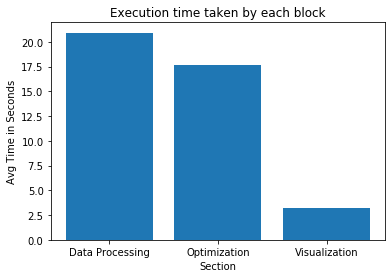

In [14]:
t2= time.time()
visual.append(t2-t1)
##############################################################################################

time_taken = {
            'Data Processing': sum(process)/len(process),
            'Optimization': sum(optimization)/len(optimization),
            'Visualization' : sum(visual)/len(visual)
    
}
plt.bar(range(len(time_taken)), time_taken.values(), align='center')
plt.xticks(range(len(time_taken)), [*time_taken])
plt.xlabel('Section')
plt.ylabel('Avg Time in Seconds')
plt.title('Execution time taken by each block')

plt.show()